In [1]:
pip install numpy pandas matplotlib scikit-learn torch torchvision

Device: cpu
X shape: (569, 30)
Classes: [0 1] counts: [212 357]
Explained variance (first 5): [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768]
Cumulative (first 5): [0.44272026 0.63243208 0.72636371 0.79238506 0.84734274]


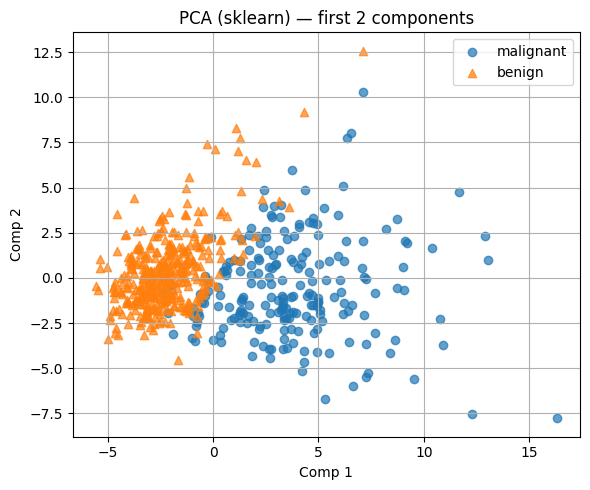

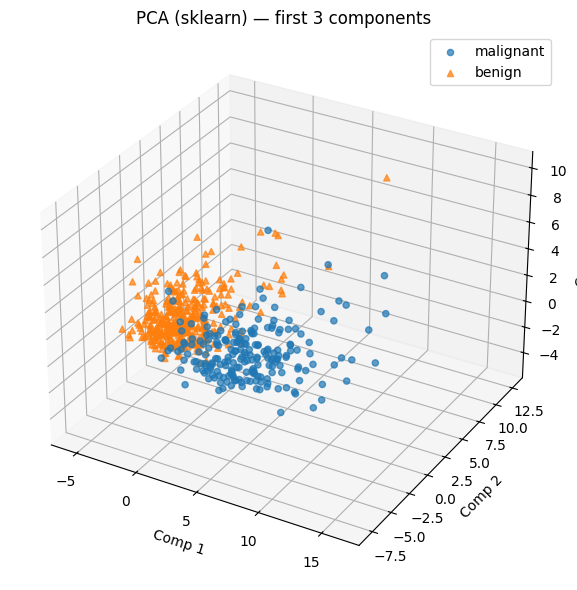

Manual PCA explained (first 5): [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768]


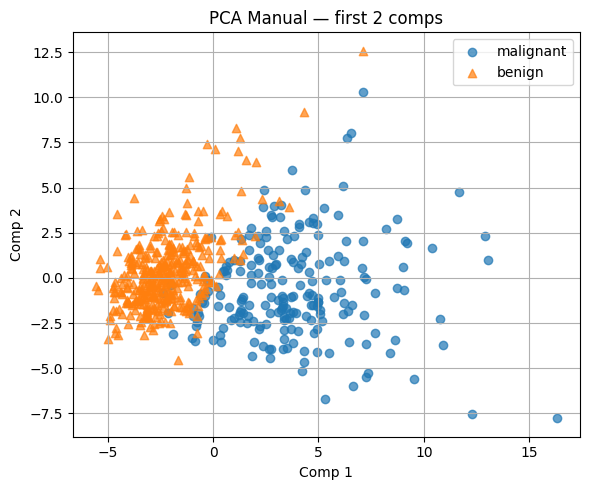

AE bottleneck=2 Epoch 40/200 loss=0.264760
AE bottleneck=2 Epoch 80/200 loss=0.241484
AE bottleneck=2 Epoch 120/200 loss=0.224059
AE bottleneck=2 Epoch 160/200 loss=0.210961
AE bottleneck=2 Epoch 200/200 loss=0.203697
Training time (s): 9.974945545196533
AE bottleneck=3 Epoch 40/200 loss=0.186860
AE bottleneck=3 Epoch 80/200 loss=0.158790
AE bottleneck=3 Epoch 120/200 loss=0.143647
AE bottleneck=3 Epoch 160/200 loss=0.128834
AE bottleneck=3 Epoch 200/200 loss=0.119338
Training time (s): 9.737640857696533


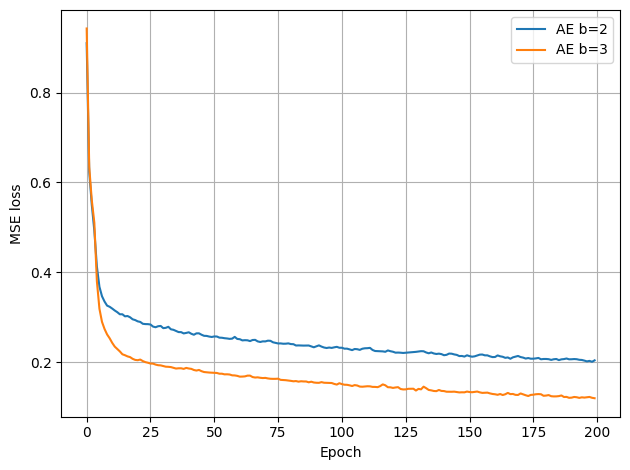

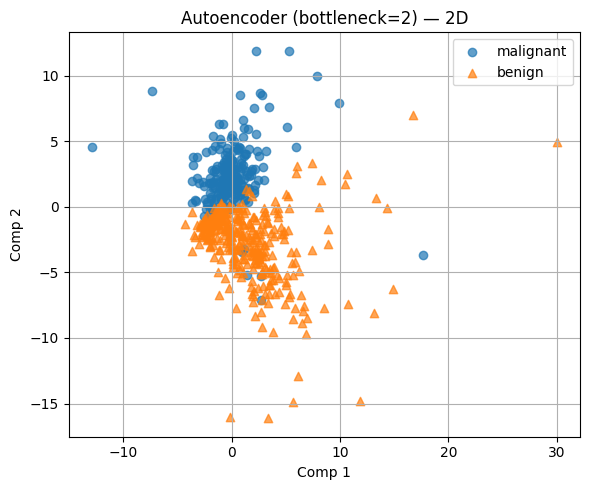

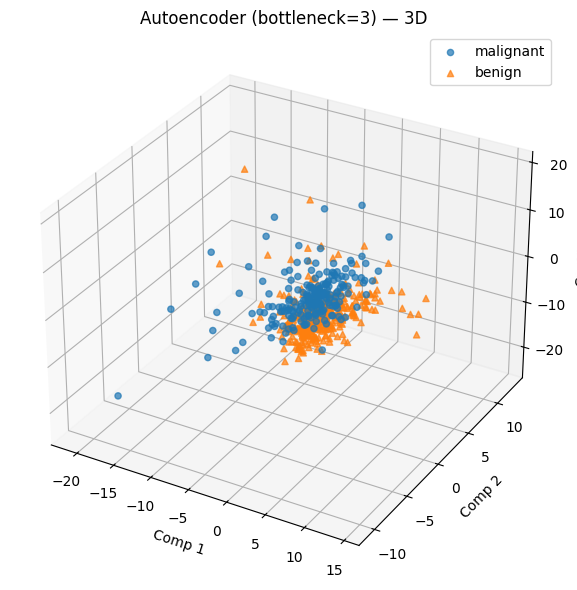

t-SNE (2D, perplexity=30) took 4.4s


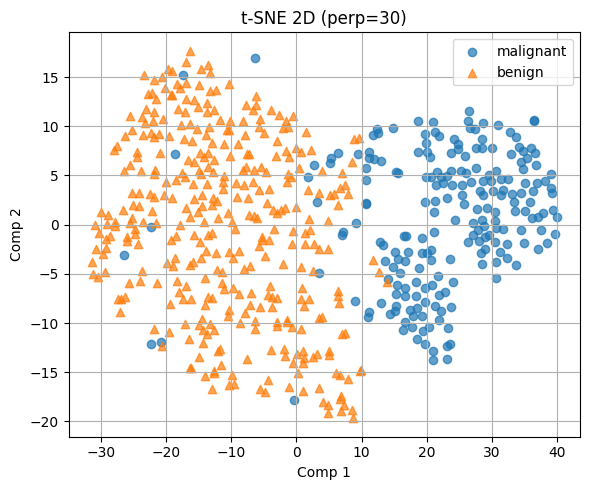

t-SNE (3D, perplexity=30) took 11.8s


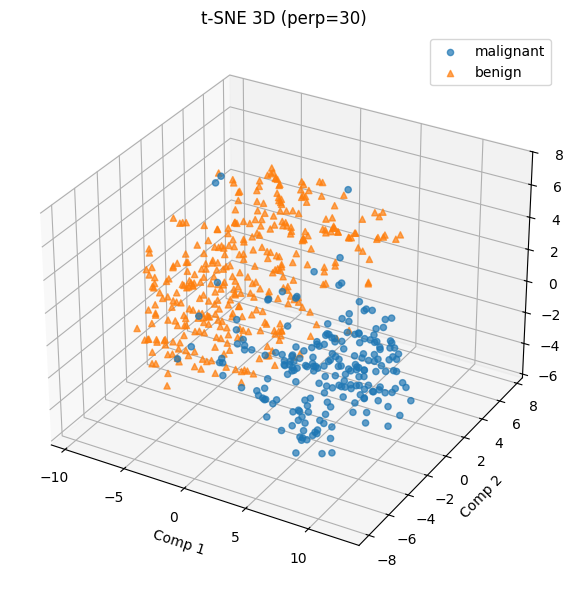

t-SNE (2D, perplexity=50) took 6.1s


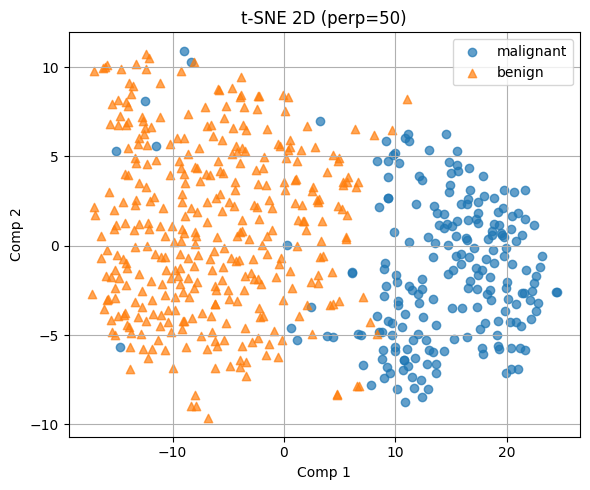

Reconstruction MSEs:
AE b=2: 0.20178481743804338
AE b=3: 0.11560294664539887
PCA k=2: 0.36756792348440565
PCA k=3: 0.2736362909100916
Saved summary to wdbc_results/summary.json


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time

OUTDIR = "wdbc_results"
os.makedirs(OUTDIR, exist_ok=True)
RND = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

data_bunch = load_breast_cancer(as_frame=True)
X_df = data_bunch.data.copy()
y = data_bunch.target.copy()

print("X shape:", X_df.shape)
print("Classes:", np.unique(y), "counts:", np.bincount(y))

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
feature_names = X_df.columns.tolist()

def plot_2d(scores, labels, title, fname):
    plt.figure(figsize=(6,5))
    classes = np.unique(labels)
    markers = ['o', '^']
    colors = ['tab:blue', 'tab:orange']
    for i, cls in enumerate(classes):
        mask = labels==cls
        plt.scatter(scores[mask,0], scores[mask,1],
                    label=data_bunch.target_names[cls], marker=markers[i%len(markers)], alpha=0.7)
    plt.xlabel('Comp 1'); plt.ylabel('Comp 2'); plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=150)
    plt.show()

def plot_3d(scores, labels, title, fname):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    classes = np.unique(labels)
    markers = ['o', '^']
    for i, cls in enumerate(classes):
        mask = labels==cls
        ax.scatter(scores[mask,0], scores[mask,1], scores[mask,2],
                   label=data_bunch.target_names[cls], marker=markers[i%len(markers)], alpha=0.7)
    ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=150)
    plt.show()

pca_full = PCA(n_components=X_scaled.shape[1], random_state=RND)
scores_pca_full = pca_full.fit_transform(X_scaled)
explained_ratio = pca_full.explained_variance_ratio_
cum_expl = np.cumsum(explained_ratio)
print("Explained variance (first 5):", explained_ratio[:5])
print("Cumulative (first 5):", cum_expl[:5])

scores_pca_2 = scores_pca_full[:,:2]
scores_pca_3 = scores_pca_full[:,:3]
plot_2d(scores_pca_2, y.values, "PCA (sklearn) — first 2 components", "pca_2d.png")
plot_3d(scores_pca_3, y.values, "PCA (sklearn) — first 3 components", "pca_3d.png")

cov = np.cov(X_scaled, rowvar=False)
eig_vals, eig_vecs = np.linalg.eig(cov)
idx = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[idx].real
eig_vecs_sorted = eig_vecs[:, idx].real
explained_manual = eig_vals_sorted / eig_vals_sorted.sum()
print("Manual PCA explained (first 5):", explained_manual[:5])

scores_manual_2 = (X_scaled - X_scaled.mean(axis=0)).dot(eig_vecs_sorted[:, :2])
plot_2d(scores_manual_2, y.values, "PCA Manual — first 2 comps", "pca_manual_2d.png")

class AutoencoderFC(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, bottleneck_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec, z

def train_autoencoder(X, bottleneck_dim, epochs=100, batch_size=32, lr=1e-3):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    ds = TensorDataset(X_tensor, X_tensor)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = AutoencoderFC(X.shape[1], bottleneck_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = []
    t0 = time.time()
    for ep in range(epochs):
        model.train()
        ep_loss = 0.0
        for xb, _ in loader:
            xb = xb.to(device)
            xr, _ = model(xb)
            loss = loss_fn(xr, xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            ep_loss += loss.item() * xb.size(0)
        ep_loss /= len(ds)
        history.append(ep_loss)
        if (ep+1) % max(1, epochs//5) == 0:
            print(f"AE bottleneck={bottleneck_dim} Epoch {ep+1}/{epochs} loss={ep_loss:.6f}")
    t1 = time.time()
    print("Training time (s):", t1-t0)
    return model, history

ae2, h2 = train_autoencoder(X_scaled, bottleneck_dim=2, epochs=200, batch_size=32, lr=1e-3)
ae3, h3 = train_autoencoder(X_scaled, bottleneck_dim=3, epochs=200, batch_size=32, lr=1e-3)

plt.figure()
plt.plot(h2, label='AE b=2')
plt.plot(h3, label='AE b=3')
plt.xlabel('Epoch'); plt.ylabel('MSE loss'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "ae_losses.png")); plt.show()

def get_latent(model, X):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        _, z = model(X_t)
        return z.cpu().numpy()

z2 = get_latent(ae2, X_scaled)
z3 = get_latent(ae3, X_scaled)

plot_2d(z2, y.values, "Autoencoder (bottleneck=2) — 2D", "ae_b2_2d.png")
plot_3d(z3, y.values, "Autoencoder (bottleneck=3) — 3D", "ae_b3_3d.png")

def run_tsne(X, n_components=2, perplexity=30, init='pca', random_state=RND):
    ts = TSNE(n_components=n_components, perplexity=perplexity, init=init, random_state=random_state)
    start=time.time()
    X_emb = ts.fit_transform(X)
    print(f"t-SNE ({n_components}D, perplexity={perplexity}) took {time.time()-start:.1f}s")
    return X_emb

tsne2_p30 = run_tsne(X_scaled, n_components=2, perplexity=30)
plot_2d(tsne2_p30, y.values, "t-SNE 2D (perp=30)", "tsne_2d_p30.png")

tsne3_p30 = run_tsne(X_scaled, n_components=3, perplexity=30)
plot_3d(tsne3_p30, y.values, "t-SNE 3D (perp=30)", "tsne_3d_p30.png")

tsne2_p50 = run_tsne(X_scaled, n_components=2, perplexity=50)
plot_2d(tsne2_p50, y.values, "t-SNE 2D (perp=50)", "tsne_2d_p50.png")

from sklearn.metrics import mean_squared_error
def reconstruction_mse_ae(model, X):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        xr, _ = model(X_t)
        xr = xr.cpu().numpy()
    return mean_squared_error(X, xr)

mse_ae2 = reconstruction_mse_ae(ae2, X_scaled)
mse_ae3 = reconstruction_mse_ae(ae3, X_scaled)
def pca_reconstruction_mse(pca_model, X, k):
    comp = pca_model.components_[:k]
    mean = pca_model.mean_
    scores = (X - mean).dot(comp.T)
    X_rec = scores.dot(comp) + mean
    return mean_squared_error(X, X_rec)

mse_pca2 = pca_reconstruction_mse(pca_full, X_scaled, 2)
mse_pca3 = pca_reconstruction_mse(pca_full, X_scaled, 3)

print("Reconstruction MSEs:")
print("AE b=2:", mse_ae2)
print("AE b=3:", mse_ae3)
print("PCA k=2:", mse_pca2)
print("PCA k=3:", mse_pca3)

summary = {
    'explained_variance_ratio_first3': explained_ratio[:3].tolist(),
    'ae_b2_recon_mse': float(mse_ae2),
    'ae_b3_recon_mse': float(mse_ae3),
    'pca_k2_mse': float(mse_pca2),
    'pca_k3_mse': float(mse_pca3)
}
import json
with open(os.path.join(OUTDIR, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print("Saved summary to", os.path.join(OUTDIR, 'summary.json'))
